In [1]:
MAKE_BOOK_FIGURES=True

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')
import seaborn as sns
sns.set_context("paper")
sns.set_style("ticks")

def set_book_style():
    plt.style.use('seaborn-v0_8-white') 
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings
        'font.family': 'serif',  # For academic publishing
        'font.size': 8,  # As requested, 10pt font
        'axes.labelsize': 8,
        'axes.titlesize': 8,
        'xtick.labelsize': 7,  # Slightly smaller for better readability
        'ytick.labelsize': 7,
        'legend.fontsize': 7,
        
        # Line and marker settings for consistency
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout to prevent clipped labels
        'figure.constrained_layout.use': True,
        
        # Default DPI (will override when saving)
        'figure.dpi': 600,
        'savefig.dpi': 600,
        
        # Despine - remove top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional trim settings
        'figure.autolayout': True,  # Alternative to constrained_layout
        'savefig.bbox': 'tight',    # Trim when saving
        'savefig.pad_inches': 0.1   # Small padding to ensure nothing gets cut off
    })

def set_notebook_style():
    plt.style.use('seaborn-v0_8-white')
    sns.set_style("ticks")
    sns.set_palette("deep")

    mpl.rcParams.update({
        # Font settings - using default sizes
        'font.family': 'serif',
        'axes.labelsize': 10,
        'axes.titlesize': 10,
        'xtick.labelsize': 9,
        'ytick.labelsize': 9,
        'legend.fontsize': 9,
        
        # Line and marker settings
        'axes.linewidth': 0.5,
        'grid.linewidth': 0.5,
        'lines.linewidth': 1.0,
        'lines.markersize': 4,
        
        # Layout settings
        'figure.constrained_layout.use': True,
        
        # Remove only top and right spines
        'axes.spines.top': False,
        'axes.spines.right': False,
        
        # Remove legend frame
        'legend.frameon': False,
        
        # Additional settings
        'figure.autolayout': True,
        'savefig.bbox': 'tight',
        'savefig.pad_inches': 0.1
    })

def save_for_book(fig, filename, is_vector=True, **kwargs):
    """
    Save a figure with book-optimized settings.
    
    Parameters:
    -----------
    fig : matplotlib figure
        The figure to save
    filename : str
        Filename without extension
    is_vector : bool
        If True, saves as vector at 1000 dpi. If False, saves as raster at 600 dpi.
    **kwargs : dict
        Additional kwargs to pass to savefig
    """    
    # Set appropriate DPI and format based on figure type
    if is_vector:
        dpi = 1000
        ext = '.pdf'
    else:
        dpi = 600
        ext = '.tif'
    
    # Save the figure with book settings
    fig.savefig(f"{filename}{ext}", dpi=dpi, **kwargs)

def make_full_width_fig():
    return plt.subplots(figsize=(4.7, 2.9), constrained_layout=True)

def make_half_width_fig():
    return plt.subplots(figsize=(2.35, 1.45), constrained_layout=True)

if MAKE_BOOK_FIGURES:
    set_book_style()
else:
    set_notebook_style()

make_full_width_fig = make_full_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()
make_half_width_fig = make_half_width_fig if MAKE_BOOK_FIGURES else lambda: plt.subplots()

(lecture15:polynomial-regression)=
# Polynomial Regression

We take up where we left off in the previous section.
Recall that we tried to fit a linear regression model to data generated from:

$$
y_i = -0.5 + 2x_i + 2x_i^2 + \epsilon_i,
$$

where $\epsilon_i \sim N(0, 1)$ and where we sample $x_i \sim U([-1,1])$:

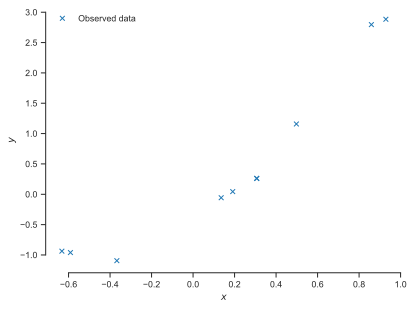

In [2]:
np.random.seed(12345)

num_obs = 10
x = -1.0 + 2 * np.random.rand(num_obs)
w0_true = -0.5
w1_true = 2.0
w2_true = 2.0
sigma_true = 0.1
y = (
    w0_true 
    + w1_true * x 
    + w2_true * x ** 2 
    + sigma_true * np.random.randn(num_obs)
)

fig, ax = plt.subplots()
ax.plot(x, y, 'x', label='Observed data')
ax.set_xlabel('$x$')
ax.set_ylabel('$y$')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

We already saw that the linear model does not work here.
We need to try to fit a quadratic model:

$$
y = w_0 + w_1 x + w_2 x^2.
$$

How can we do this? Of course, by minimizing the square loss:

$$
L(w_0, w_1, w_2) = \sum_{i=1}^n(y_i - w_0 - w_1 x_i - w_2 x_i^2)^2.
$$

Fortunately, we do not have to do things from scratch.
The notation we developed previously comes to our rescue.
Recall, that $\mathbf{y} = (y_1,\dots,y_n)$ is the vector of observations.
Use

$$
\mathbf{w} = (w_0, w_1, w_2),
$$ 

to denote the weight vector.
What about the design matrix?
Before, it was an $N\times 2$ matrix, with the first column being one and the second being the vector of observed inputs.
Well, now it is the $N\times 3$ matrix.
The first two columns are exactly like before, but now the third column is the observed inputs squared.
So, it is:

$$
\mathbf{X} = 
\begin{bmatrix} 
1 & x_1 & x_1^2\\
1 & x_2 & x_2^2\\
\vdots & \vdots \\
1 & x_n & x_n^2
\end{bmatrix}.
$$

As before, if you multiply the design matrix $\mathbf{X}$ with the weight vector $\mathbf{w}$, you get the predictions of our model.
We can write the square loss:

$$
L(w_0, w_1, w_2) = L(\mathbf{w}) = \parallel \mathbf{y} - \mathbf{X}\mathbf{w}\parallel^2.
$$

Well, this is mathematically the same equation as before.
The only difference is that we have a 3-dimensional weight vector (instead of a 2-dimensional) and that the design matrix is $n\times 3$ instead of $n\times 2$.
If you take the gradient of this with respect to $\mathbf{w}$ and set it equal to zero, you will get that you need to solve the same linear system of equations as before (but now it is three equations for three unknowns instead of two equations for two unknowns).

Let's solve it numerically.
First, the design matrix:

In [3]:
X = np.hstack(
    [
        np.ones((num_obs, 1)),
        x.reshape((num_obs, 1)),
        x.reshape((num_obs, 1)) ** 2
    ]
)
X

array([[ 1.        ,  0.85923219,  0.73827995],
       [ 1.        , -0.36724889,  0.13487175],
       [ 1.        , -0.63216238,  0.39962927],
       [ 1.        , -0.59087944,  0.34913852],
       [ 1.        ,  0.13545006,  0.01834672],
       [ 1.        ,  0.19108941,  0.03651516],
       [ 1.        ,  0.92902904,  0.86309496],
       [ 1.        ,  0.30635419,  0.09385289],
       [ 1.        ,  0.49781328,  0.24781806],
       [ 1.        ,  0.30713974,  0.09433482]])

and then:

In [4]:
w, _, _, _ = np.linalg.lstsq(X, y, rcond=None)

print(f"w = {w}")

w = [-0.4480109   2.03041492  1.8526404 ]


Let's visualize the model predictions:

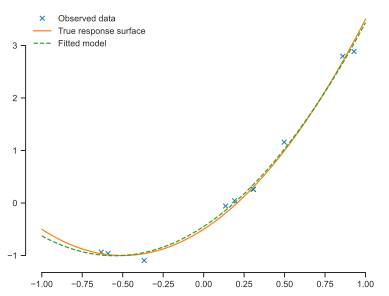

In [5]:
xx = np.linspace(-1, 1, 100)
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2
yy = w[0] + w[1] * xx + w[2] * xx ** 2

fig, ax = plt.subplots()
ax.plot(x, y, 'x', label='Observed data')
ax.plot(xx, yy_true, label='True response surface')
ax.plot(xx, yy, '--', label='Fitted model')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Questions

+ Repeat with very small ``num_obs`` and very large ``num_obs`` and observe the behavior of the fit.

## Regression with high-degree polynomials and overfitting

What would have happened if we tried to use a higher-degree polynomial?
To achieve this, we need to be able to evaluate a design matrix of the form:

$$
\mathbf{X} = 
\begin{bmatrix} 
1 & x_1 & x_1^2\dots & x_1^\rho\\
1 & x_2 & x_2^2\dots & x_2^\rho\\
\vdots & \vdots\dots & \vdots\\
1 & x_n & x_n^2 \dots & x_n^\rho
\end{bmatrix},
$$

where $\rho$ is the degree of the polynomial.
The linear system we need to solve is the same as before.
The weight vector is $\rho + 1$ dimensional and the design matrix $n\times (\rho + 1)$.

Let's write some code to find the design matrix:

In [6]:
def get_polynomial_design_matrix(x, degree):
    """Return the polynomial design matrix of ``degree`` evaluated at ``x``.
    
    Arguments:
    x      -- A 2D array with only one column.
    degree -- An integer greater than zero.
    """
    # Make sure this is a 2D numpy array with only one column
    assert isinstance(x, np.ndarray), 'x is not a numpy array.'
    assert x.ndim == 2, 'You must make x a 2D array.'
    assert x.shape[1] == 1, 'x must be a column.'
    # Start with an empty list where we are going to put the columns of the matrix
    cols = []
    # Loop over columns and add the polynomial
    for i in range(degree+1):
        cols.append(x ** i)
    return np.hstack(cols)

Let's try fitting a degree 3 polynomial and see what we get:

In [7]:
# The polynomial degree
degree = 3

# The design matrix is:
X = get_polynomial_design_matrix(x[:, None], degree)

# And we fit just like previously:
w, _, _, _ = np.linalg.lstsq(X, y, rcond=None)
print(f"w = {w}")

w = [-0.54336704  2.38275708  2.29024175 -0.82720627]


Let's visualize the fit.
Notice that for making predictions, I am evaluating the design matrix on the points I want to make predictions at.

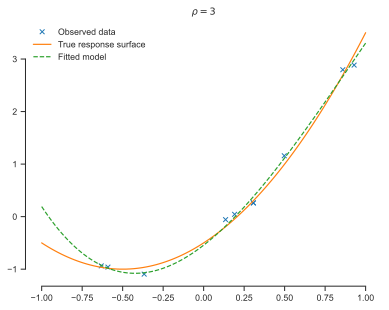

In [8]:
# Make predictions like this:
xx = np.linspace(-1, 1, 100)
XX = get_polynomial_design_matrix(xx[:, None], degree)
yy = XX @ w

# The true response
yy_true = w0_true + w1_true * xx + w2_true * xx ** 2

# Plot everything
fig, ax = plt.subplots()
ax.plot(x, y, 'x', label='Observed data')
ax.plot(xx, yy_true, label='True response surface')
ax.plot(xx, yy, '--', label='Fitted model')
ax.set_title(f'$\\rho = {degree}$')
plt.legend(loc='best', frameon=False)
sns.despine(trim=True);

## Questions

+ Start increasing the polynomial degree from 3 to 4 to a number where things get bad. You will soon start *overfitting*.